# MNIST Digits Classification using Neural Networks



In this part we will implement our first Neural Network!
We will use fully connecter Neural Network in order to classify handwritten digits. We will use the well known MNIST dataset. The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Imports

In [4]:
#importing modules that will be in use
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



Mount your drive in order to run locally with colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Deep Learning/Assignment 2/FC
from utils import *

Mounted at /content/drive
/content/drive/MyDrive/Deep Learning/Assignment 2/FC


**QUESTION 1**: What are the problems with sigmoid?

**ANSWER**: 



*   In a large area, the function has zero derivatives, which means that there are many cases where we don't have gradients that we can improve
*   The output range isn't centered around zero.










here we will implement the sigmoid activation function and it's gradient. You should not use any build-in function of sigmoid.

In [5]:

def sigmoid(x):
    # impement the sigmoid funciton
    # ====== YOUR CODE: ======
    sig = 1/(1 + torch.exp(-x))
    # ========================
    return sig



def softmax(x):
    """
  Softmax loss function, should be implemented in a vectorized fashion (without loops)


  Inputs:
  - X: A torch array of shape (N, C) containing a minibatch of data.
  Returns:
  - probabilities: A torch array of shape (N, C) containing the softmax probabilities.

     """
    #for stability (do not change)
    max_per_row, inds = torch.max(x, dim=1)
    x = (x.T - max_per_row).T
    
    # ====== YOUR CODE: ======   
    probabilities = torch.exp(x)/ sum(torch.exp(x))
    # ========================
    return probabilities

Implement a fully-vectorized loss function for the Softmax classifier.


In [6]:
def cross_entropy_error(y, t):
    """
    Inputs:

    - t:  A torch array of shape (N,C) containing  a minibatch of training label. it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: A torch array of shape (N, C) containing the softmax probabilities (the NN's output).

    Returns:
    - loss as single float (do not forget to divide by the number of samples in the minibatch (N))
    """
    # ====== YOUR CODE: ======   
    # Compute loss 
    y_size = y.shape[0]
    error = -torch.sum(t*torch.log(y))/y_size
    # ========================
    return error

In [7]:
def get_accuracy(y, t):
    """
    Computes the accuracy of the NN's predictions.
    Inputs:
    - t:  A torch array of shape (N,C) containing training labels, it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: the torch probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    Returns:
    - accuracy: a single float of the average accuracy.
    """
    # ====== YOUR CODE: ======  
    pass
    tmax = torch.argmax(t, dim=1)
    ymax = torch.argmax(y, dim=1)
    correct = (tmax.cpu().numpy() == ymax.cpu().numpy()).sum()
    accuracy = float(correct / y.shape[0])
    # ========================    
    return accuracy

## Fully-connected Network

We will design and train a two-layer fully-connected neural network with sigmoid nonlinearity and
softmax cross entropy loss. We assume an input dimension of D=784, a hidden dimension of H, and perform classification over C classes.

The architecture should be fullyconnected -> sigmoid -> fullyconnected -> softmax.

We will use torch.nn for the linear functions



### config

In [8]:
args={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=35  #The number of Epochs
args['validation_ratio']=0.15 #The validation ratio from training set  
args['eval_every']=1 #Will evaluate the model ever <eval_every> epochs

## load the data

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("using " + device)

using cuda


In [10]:
def create_train_validation_loaders(dataset: Dataset, 
                                         validation_ratio,
                                         batch_size=100):
    """
    Splits a dataset into a train and validation set, returning a
    DataLoader for each.
    :param dataset: The original dataset.
    :param validation_ratio: Ratio (in range 0,1) of the validation set size to
        total dataset size.
    :param batch_size: Batch size the loaders will return from each set.
    :return: A tuple of train, validation and test DataLoader instances.
    """
    if not(0.0 < validation_ratio < 1.0):
        raise ValueError(validation_ratio)
        
        
    # TODO: Create two DataLoader instances, dataloader_train and dataloader_valid.
    # They should together represent a train/validation split of the given
    # dataset. Make sure that:
    # 1. Validation set size is validation_ratio * total number of samples.
    # 2. No sample is in both datasets. You can select samples at random
    #    from the dataset.
    # 3. you use shuffle=True in the train dataloader and shuffle=False in the validation dataloder
    

    # ====== YOUR CODE: ======
    train_dataset, validation_dataset = train_test_split(dataset, test_size = validation_ratio, shuffle= True)
    
    dl_train = DataLoader(train_dataset, batch_size, shuffle=True)
    dl_valid = DataLoader(validation_dataset, batch_size, shuffle=False)
    # ========================

    return dl_train, dl_valid

In [11]:
#load the data
dataset = datasets.MNIST('./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Normalize((0.1307,), (0.3081,))])
                        )

train_loader, val_loader = create_train_validation_loaders(dataset, 
                                                           validation_ratio = args['validation_ratio'],
                                                           batch_size= args['batch_size'])

In [12]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [13]:
dataloaders = {'training':train_loader,
               'val':val_loader,
               'test':test_loader
              }

## Fully connected Neural Network

In [14]:
class FullyConnectedNeuralNetwork(nn.Module):
    #This defines the structure of the NN.
    def __init__(self,
                 hidden_layer_dim
                 ):
      super(FullyConnectedNeuralNetwork, self).__init__()
      # Define the model layers. 
      # Use the torch.nn.Linear layers. Set the hidden layer dim to hidden_layer_dim. 
      # Notice that the input dim is 784 and the output dim is 10 (number of classes).
      # ====== YOUR CODE: ======
      self.fc1 = torch.nn.Linear(784, hidden_layer_dim)
      self.fc2 = nn.Linear(hidden_layer_dim, 10)
      # ========================

    def forward(self, x):
      x = torch.flatten(x, start_dim=1,end_dim=-1)
      # ====== YOUR CODE: ======
      x = sigmoid(self.fc1(x))
      y = softmax(self.fc2(x))
      # ========================
      return y

The following functions will train our model

In [15]:
def forward_one_epoch(loader,
                      optimizer,
                      net,
                      mode,
                      progress_bar_str,
                      num_of_epochs
                     ):
    

    losses, cur_accuracies = [], []
    all_preds,all_targets = [], []
    for batch_idx, (inputs, targets) in enumerate(loader):
        
        if mode == Mode.training:
            optimizer.zero_grad()
            
        inputs, targets =inputs.to(device), targets.to(device)
        outputs = net(inputs)
        targets = F.one_hot(targets, num_classes=10)
        loss = cross_entropy_error(outputs, targets)
        losses.append(loss.item())

        if mode == Mode.training:
            #do a step 
            loss.backward()
            optimizer.step()
            
        if len(targets.shape) ==2:
            cur_accuracies.append(get_accuracy(outputs, targets))
            
        if batch_idx %20 ==0:
            progress_bar(batch_idx, len(loader), progress_bar_str
                   % (num_of_epochs, np.mean(losses), losses[-1], np.mean(cur_accuracies)))
            
        targets_cpu = targets.cpu().data.numpy()
        outputs_cpu = [i.cpu().data.numpy() for i in outputs]
        outputs_cpu = np.argmax(outputs_cpu, axis=1)

        all_targets.extend(targets_cpu)
        all_preds.extend(outputs_cpu)

        del inputs, targets, outputs
        torch.cuda.empty_cache()


    return losses, cur_accuracies, all_targets, all_preds




In [16]:
def train(args, dataloaders):
  seed = 0
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

  model = FullyConnectedNeuralNetwork(hidden_layer_dim = args['hidden_layer_dim'])
  model = model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), args['lr'])

  training_accuracies, val_accuracies = [], []
  training_losses, val_losses = [], [] 


  training_loader = dataloaders['training']
  val_loader = dataloaders['val']
  test_loader = dataloaders['test']

  best_acc = -1

  #start training
  for epoch in range(1, args['epochs']+1):

      #training
      model = model.train()

      progress_bar_str = 'Train: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Train Acc: %.3f%%' 

      losses, cur_training_accuracies, _,_ =  forward_one_epoch(
          loader = training_loader,
          optimizer = optimizer,
          net = model,
          mode = Mode.training,
          progress_bar_str = progress_bar_str,
          num_of_epochs = epoch)


      train_epoch_acc = np.mean(cur_training_accuracies)
      train_epoch_loss= np.mean(losses)
      sys.stdout.flush()
      print()
      print(f'Train epoch {epoch}: accuracy {train_epoch_acc}, loss {train_epoch_loss}', flush=True)
      training_accuracies.append(train_epoch_acc)
      training_losses.append(train_epoch_loss)



      # validation
      model.eval()
      if (epoch-1)%args['eval_every']==0:
          progress_bar_str = 'Validation: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | val Acc: %.3f%%'

          losses, cur_val_accuracies,_,_ =  forward_one_epoch(val_loader,
                                                                optimizer,
                                                                model,
                                                                Mode.validation,
                                                                progress_bar_str,
                                                                epoch
                                                              )
          val_epoch_acc= np.mean(cur_val_accuracies)
          val_epoch_loss= np.mean(losses)
          sys.stdout.flush()
          val_accuracies.append(val_epoch_acc)

          val_epoch_acc = np.round(val_epoch_acc,3)
          print()
          print(f'Validation epoch {epoch//args["eval_every"]}: accuracy {val_epoch_acc}, loss {val_epoch_loss}', flush=True)
          val_losses.append(val_epoch_loss)
          
          cur_acc_loss = {
            'training_accuracies':training_accuracies,
            'val_accuracies':val_accuracies,
            'training_losses':training_losses,
            'val_losses':val_losses
                        }

          if best_acc +0.001 < val_epoch_acc:

              best_acc = val_epoch_acc
              best_acc_epoch = epoch

              print(f'========== new best model! epoch {best_acc_epoch}, accuracy {best_acc}  ==========')
              best_model = copy.deepcopy(model)

              
  progress_bar_str = 'Test: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Acc: %.3f%%'
  test_losses, test_cur_test_accuracies, test_all_targets, test_all_preds = forward_one_epoch(test_loader,
                                                                None,
                                                                best_model,
                                                                Mode.test,
                                                                progress_bar_str,
                                                                0)

  test_epoch_acc= np.mean(test_cur_test_accuracies)
  test_epoch_loss= np.mean(test_losses)
  print("===================== Test Results =====================")
  print(f'Test Accuracy : {test_epoch_acc}')
  print(f'Test Loss : {test_epoch_loss}')
  return best_model, cur_acc_loss 

## Training Process

We will finetune two hyper parameters:
1. The hidden layer dimension.
2. The learning rate.

### Finetuning hidden_layer_dim 

#### hidden_layer_dim = 1, lr = 0.0001  

Set the hidden_layer_dim to 1 and the lr to 0.0001 and train the model.

In [17]:
args['hidden_layer_dim'] = 1
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.12845098039215685, loss 6.907244373770321

Validation epoch 1: accuracy 0.131, loss 6.906352255079481
========== new best model! epoch 1, accuracy 0.131  ==========

Train epoch 2: accuracy 0.13039215686274508, loss 6.906633947409835

Validation epoch 2: accuracy 0.133, loss 6.90578916337755
========== new best model! epoch 2, accuracy 0.133  ==========

Train epoch 3: accuracy 0.13264705882352942, loss 6.9060695966084795

Validation epoch 3: accuracy 0.135, loss 6.90523714489407
========== new best model! epoch 3, accuracy 0.135  ==========

Train epoch 4: accuracy 0.13505882352941176, loss 6.905509677587771

Validation epoch 4: accuracy 0.136, loss 6.9046963055928545

Train epoch 5: accuracy 0.13766666666666666, loss 6.904967279995189

Validation epoch 5: accuracy 0.138, loss 6.904165691799587
========== new best model! epoch 5, accuracy 0.138  ==========

Train epoch 6: accuracy 0.1401372549019608, loss 6.904422320571601

Validation epoch 6: accuracy 0.14,

Best val accuracy was 0.18144444444444446, at epoch 33


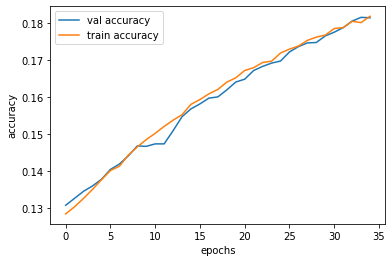

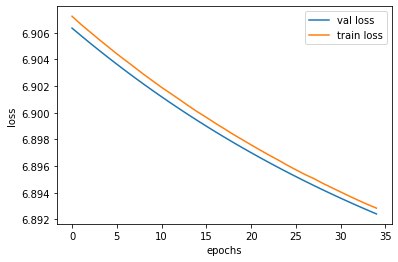

0.18144444444444446

In [18]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.1829

Test Loss : 6.892094945907592

On the graph we can see that as we make more epochs the model is getting better and the accuracy is increasing while the loss is decreasing.

Despite the improvements, accuracy is still low, and the loss is still high, which suggests that the hidden layer dim is too small, which weakens the model.


#### hidden_layer_dim = 5, lr = 0.0001

Set the hidden_layer_dim to 5 and the lr to 0.0001 and train the model.

In [19]:
args['hidden_layer_dim'] = 5
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.15229411764705883, loss 6.886387647366991

Validation epoch 1: accuracy 0.153, loss 6.886606163448757
========== new best model! epoch 1, accuracy 0.153  ==========

Train epoch 2: accuracy 0.155921568627451, loss 6.88534335529103

Validation epoch 2: accuracy 0.157, loss 6.8856054411994085
========== new best model! epoch 2, accuracy 0.157  ==========

Train epoch 3: accuracy 0.15964705882352945, loss 6.8843277575922945

Validation epoch 3: accuracy 0.16, loss 6.884608427683513
========== new best model! epoch 3, accuracy 0.16  ==========

Train epoch 4: accuracy 0.16358823529411767, loss 6.883308457393272

Validation epoch 4: accuracy 0.163, loss 6.88361570570204
========== new best model! epoch 4, accuracy 0.163  ==========

Train epoch 5: accuracy 0.1674117647058824, loss 6.882306931065578

Validation epoch 5: accuracy 0.167, loss 6.882627063327366
========== new best model! epoch 5, accuracy 0.167  ==========

Train epoch 6: accuracy 0.1716078431372549, 

Best val accuracy was 0.27244444444444443, at epoch 34


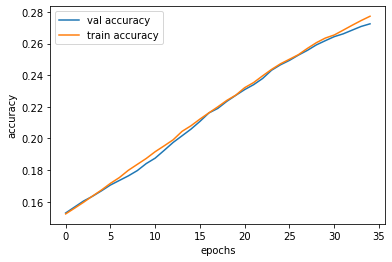

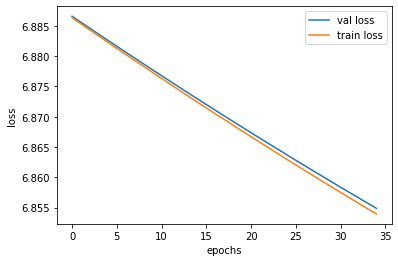

0.27244444444444443

In [20]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.2785

Test Loss : 6.8530741214752195

The graphs are similar to the previous graphs, but one can see that after increasing the hidden layer dimension, the accuracy has improved, and the loss has decreased, although it's still not good enough, we can also see that the improvement between epochs is very small, which implies that the learning rate is too low, and the hidden layer dimension is still too small.


#### hidden_layer_dim = 100, lr = 0.0001

Set the hidden_layer_dim to 100 and the lr to 0.0001 and train the model.

In [21]:
args['hidden_layer_dim'] = 100
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.11154901960784314, loss 6.907572147892971

Validation epoch 1: accuracy 0.111, loss 6.9067666795518665
========== new best model! epoch 1, accuracy 0.111  ==========

Train epoch 2: accuracy 0.11547058823529412, loss 6.906422951642205

Validation epoch 2: accuracy 0.116, loss 6.905623859829372
========== new best model! epoch 2, accuracy 0.116  ==========

Train epoch 3: accuracy 0.11921568627450982, loss 6.90526985654644

Validation epoch 3: accuracy 0.121, loss 6.9044826295640735
========== new best model! epoch 3, accuracy 0.121  ==========

Train epoch 4: accuracy 0.12382352941176471, loss 6.904110300774668

Validation epoch 4: accuracy 0.125, loss 6.903342035081652
========== new best model! epoch 4, accuracy 0.125  ==========

Train epoch 5: accuracy 0.12845098039215685, loss 6.902970501020843

Validation epoch 5: accuracy 0.13, loss 6.902203612857395
========== new best model! epoch 5, accuracy 0.13  ==========

Train epoch 6: accuracy 0.13280392156862

Best val accuracy was 0.2573333333333333, at epoch 34


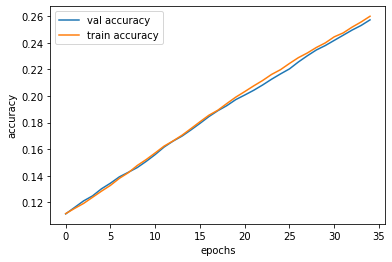

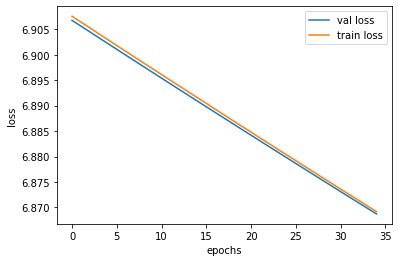

0.2573333333333333

In [22]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.2509

Test Loss : 6.870093584060669

As we saw in the previous train, the model is improving between every epoch, but the improvement is too slow, probably because the learning rate is too low. 


#### hidden_layer_dim = 200, lr = 0.0001

Set the hidden_layer_dim to 200 and the lr to 0.0001 and train the model.

In [23]:
args['hidden_layer_dim'] = 200
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.12966666666666668, loss 6.897243266012154

Validation epoch 1: accuracy 0.135, loss 6.896122349633111
========== new best model! epoch 1, accuracy 0.135  ==========

Train epoch 2: accuracy 0.13490196078431374, loss 6.89590757968379

Validation epoch 2: accuracy 0.14, loss 6.894793298509386
========== new best model! epoch 2, accuracy 0.14  ==========

Train epoch 3: accuracy 0.14049019607843138, loss 6.894569350223915

Validation epoch 3: accuracy 0.146, loss 6.893466154734294
========== new best model! epoch 3, accuracy 0.146  ==========

Train epoch 4: accuracy 0.14572549019607844, loss 6.893234832614076

Validation epoch 4: accuracy 0.153, loss 6.892140706380208
========== new best model! epoch 4, accuracy 0.153  ==========

Train epoch 5: accuracy 0.15013725490196075, loss 6.8919111887613935

Validation epoch 5: accuracy 0.157, loss 6.890817218356663
========== new best model! epoch 5, accuracy 0.157  ==========

Train epoch 6: accuracy 0.157039215686274

Best val accuracy was 0.34800000000000003, at epoch 34


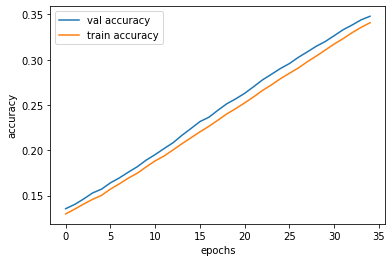

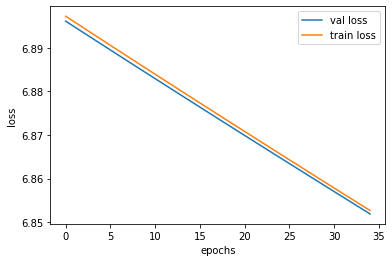

0.34800000000000003

In [24]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.4**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.3556

Test Loss : 6.849764823913574

We can see from those graphs that train and test sets get almost the same results. That means that the model isn't learning only the test samples (overfitting), but that it exceeds to get the same accuracy for both graphs as well. 
As for the LR, its low value affects the model as we described above.

### Finetuning learning rate

#### hidden_layer_dim = 100, lr = 0.000001

Set the hidden_layer_dim to 100 and the lr to 0.000001 and train the model.

In [25]:
args['hidden_layer_dim'] = 100
args['lr']=0.000001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.10978431372549018, loss 6.908131552677529

Validation epoch 1: accuracy 0.108, loss 6.9078994856940374
========== new best model! epoch 1, accuracy 0.108  ==========

Train epoch 2: accuracy 0.10939215686274509, loss 6.908123371647854

Validation epoch 2: accuracy 0.108, loss 6.907888094584147

Train epoch 3: accuracy 0.10929411764705882, loss 6.908109795813467

Validation epoch 3: accuracy 0.108, loss 6.907876650492351

Train epoch 4: accuracy 0.10925490196078433, loss 6.9080898154015635

Validation epoch 4: accuracy 0.108, loss 6.9078653123643665

Train epoch 5: accuracy 0.10952941176470588, loss 6.908086804782643

Validation epoch 5: accuracy 0.108, loss 6.90785386827257

Train epoch 6: accuracy 0.10952941176470589, loss 6.908066964616962

Validation epoch 6: accuracy 0.108, loss 6.907842583126492

Train epoch 7: accuracy 0.10968627450980392, loss 6.908057895361209

Validation epoch 7: accuracy 0.108, loss 6.907831403944227

Train epoch 8: accuracy 0.10952

Best val accuracy was 0.10899999999999999, at epoch 34


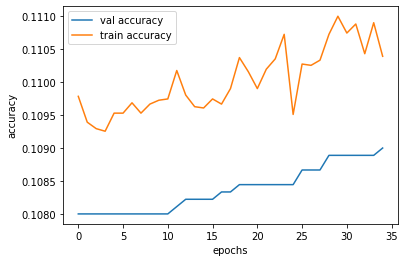

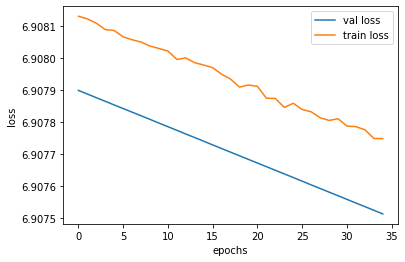

0.10899999999999999

In [26]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.0982

Test Loss : 6.910411262512207

We can se that between the epochs the accuaracy and loss rate is barely change, the LR is too low.



#### hidden_layer_dim = 100, lr = 0.1

Set the hidden_layer_dim to 1 and the lr to 0.1 and train the model.

In [27]:
args['hidden_layer_dim'] = 100
args['lr']= 0.1
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.6672549019607843, loss 6.411017361809225

Validation epoch 1: accuracy 0.773, loss 5.959825780656603
========== new best model! epoch 1, accuracy 0.773  ==========

Train epoch 2: accuracy 0.8112352941176472, loss 5.69456771775788

Validation epoch 2: accuracy 0.829, loss 5.511635356479221
========== new best model! epoch 2, accuracy 0.829  ==========

Train epoch 3: accuracy 0.851156862745098, loss 5.389483517291499

Validation epoch 3: accuracy 0.857, loss 5.31518734825982
========== new best model! epoch 3, accuracy 0.857  ==========

Train epoch 4: accuracy 0.8721372549019606, loss 5.240319794299555

Validation epoch 4: accuracy 0.87, loss 5.205674860212538
========== new best model! epoch 4, accuracy 0.87  ==========

Train epoch 5: accuracy 0.8839411764705883, loss 5.153197952345306

Validation epoch 5: accuracy 0.879, loss 5.137755076090495
========== new best model! epoch 5, accuracy 0.879  ==========

Train epoch 6: accuracy 0.891921568627451, loss 5

Best val accuracy was 0.9296666666666668, at epoch 33


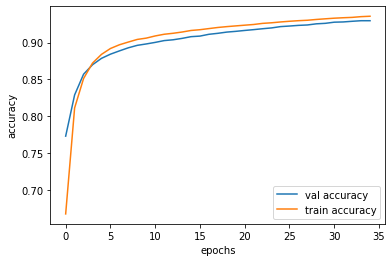

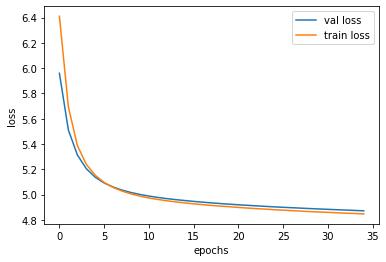

0.9296666666666668

In [28]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.9355999999999998

Test Loss : 4.850043487548828

Based on the learning rate and hidden layer dimension, we can see that both the accuracy and the loss are improving significantly between epochs, for both train and validation sets.
As we said before because of the low learning rate, we didn't improve between epochs. Now we can see the effect of higher learning rate.


#### hidden_layer_dim = 100, lr = 0.001

Set the hidden_layer_dim to 100 and the lr to 0.001 and train the model.

In [29]:
args['hidden_layer_dim'] = 100
args['lr']=0.001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.13125490196078432, loss 6.902504350624833

Validation epoch 1: accuracy 0.151, loss 6.8965277671813965
========== new best model! epoch 1, accuracy 0.151  ==========

Train epoch 2: accuracy 0.1771372549019608, loss 6.89110309937421

Validation epoch 2: accuracy 0.197, loss 6.885296450720893
========== new best model! epoch 2, accuracy 0.197  ==========

Train epoch 3: accuracy 0.22205882352941178, loss 6.879847638747272

Validation epoch 3: accuracy 0.238, loss 6.874211311340332
========== new best model! epoch 3, accuracy 0.238  ==========

Train epoch 4: accuracy 0.26054901960784316, loss 6.868710265440099

Validation epoch 4: accuracy 0.276, loss 6.8632498317294655
========== new best model! epoch 4, accuracy 0.276  ==========

Train epoch 5: accuracy 0.2957450980392157, loss 6.8577233856799555

Validation epoch 5: accuracy 0.312, loss 6.852397123972575
========== new best model! epoch 5, accuracy 0.312  ==========

Train epoch 6: accuracy 0.3296470588235

Best val accuracy was 0.6974444444444443, at epoch 34


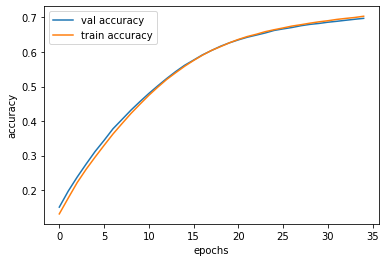

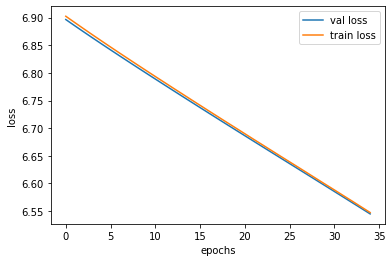

0.6974444444444443

In [30]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.7202999999999999

Test Loss : 6.5369964122772215

the accuracy and loss got worst from last attempt, the only thing we changed is to decrease the LR.

Again, the improvements between epochs are too slow - the LR is too small.

**QUESTION 4:** : Suggest a way to improve the results by changing the networks's architecture  

**ANSWER**:

It is possible to create more hidden layers.

The more hidden layers we add to the model, the deeper the model can learn, meaning it will learn more distinctive and unique features through each hidden layer. 





## Explainability

Here we will plot some of the network weights

In [32]:
args['hidden_layer_dim'] = 100
args['lr'] = 0.1
best_model, cur_acc_loss = train(args, dataloaders)


Train epoch 1: accuracy 0.6672549019607843, loss 6.411017361809225

Validation epoch 1: accuracy 0.773, loss 5.959825780656603
========== new best model! epoch 1, accuracy 0.773  ==========

Train epoch 2: accuracy 0.8112352941176472, loss 5.69456771775788

Validation epoch 2: accuracy 0.829, loss 5.511635356479221
========== new best model! epoch 2, accuracy 0.829  ==========

Train epoch 3: accuracy 0.851156862745098, loss 5.389483517291499

Validation epoch 3: accuracy 0.857, loss 5.31518734825982
========== new best model! epoch 3, accuracy 0.857  ==========

Train epoch 4: accuracy 0.8721372549019606, loss 5.240319794299555

Validation epoch 4: accuracy 0.87, loss 5.205674860212538
========== new best model! epoch 4, accuracy 0.87  ==========

Train epoch 5: accuracy 0.8839411764705883, loss 5.153197952345306

Validation epoch 5: accuracy 0.879, loss 5.137755076090495
========== new best model! epoch 5, accuracy 0.879  ==========

Train epoch 6: accuracy 0.891921568627451, loss 5

(784, 100)


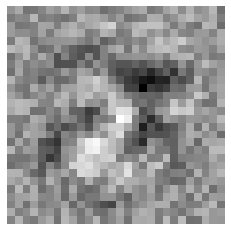

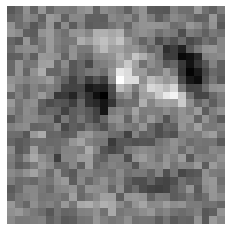

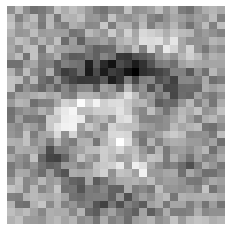

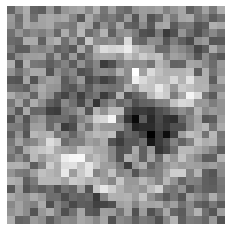

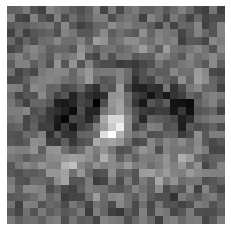

In [33]:
# Visualize some weights. features of digits should be somehow present.
def show_net_weights(net_params):
    W1 = net_params.fc1.weight.cpu().data.numpy().T
    print(W1.shape)
    for i in range(5):
        W = W1[:,i*5].reshape(28, 28)
        plt.imshow(W,cmap='gray')
        plt.axis('off')
        plt.show()

show_net_weights(best_model)


**QUESTION 5:** Where are the bright regions? why?

**ANSWER:** 

the brightest region can be found in the middle.

The reason is that the most of the features can be found in the center area of any photo of digit.